# Phenotype generation

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [25]:
ped = np.loadtxt("data/hapmap1.ped", usecols=xrange(6, 167074), dtype=int)

In [75]:
# randomly pick 10 SNPs to be causal
np.random.seed(42)
#causal_SNPs = list(np.random.randint(0, high=83534, size=10))
#causal_SNPs.sort()
#print causal_SNPs

causal_SNPs = set([])
while len(causal_SNPs) < 10:
    idx = np.random.randint(0, high=83534)
    if not len(np.where(ped[:, 2*idx]==0)[0]):
            causal_SNPs.add(idx)
causal_SNPs = list(causal_SNPs)
causal_SNPs.sort()

print causal_SNPs

[860, 6265, 15795, 37194, 41090, 44131, 60263, 67221, 76820, 82386]


In [117]:
# randomly pick 9 causal weights (SNP0 and SNP2 will be in epistasis)
np.random.seed(42)
#causal_weights = np.random.uniform(low=-2., high=2., size=9)
causal_weights = np.random.normal(size=9)
print ["%.3f" % w for w in causal_weights]

['0.497', '-0.138', '0.648', '1.523', '-0.234', '-0.234', '1.579', '0.767', '-0.469']


In [82]:
# transform ped into only causal features
print ped.shape
causal_X = np.array([4-(ped[:, idx*2]+ped[:, idx*2+1]) for idx in causal_SNPs]).T
print causal_X.shape

(89, 167068)
(89, 10)


In [84]:
causal_X[:, 0] = causal_X[:, 0]*causal_X[:, 2]

In [86]:
causal_X = np.delete(causal_X, 2, 1)
print causal_X.shape

(89, 9)


In [119]:
y = np.dot(causal_X, causal_weights)
print y.shape

(89,)


[ 0.44173171  0.79332073  0.38501709  0.70615566  0.33101203  0.56526568
  0.5         0.38501709  0.86315833  0.28134876  0.51624204  0.75229799
  0.56526568  0.62834458  0.38502098  0.33127065  0.50710137  0.38501709
  0.56526568  0.38502487  0.56526972  0.50710548  0.62168683  0.35284553
  0.68296571  0.44172766  0.79332073  0.44172766  0.68296571  0.56526568
  0.38501709  0.38501709  0.44172766  0.73691502  0.45752016  0.75230105
  0.44172766  0.79332073  0.5         0.44172766  0.70615225  0.70615225
  0.68908437  0.3310084   0.50710137  0.28135208  0.91201613  0.44172766
  0.57223716  0.56526568  0.5         0.23650846  0.62168683  0.40795696
  0.38502098  0.68119629  0.38501709  0.63024811  0.5         0.44875231
  0.38501709  0.56526568  0.57223716  0.44172766  0.44173171  0.44172766
  0.38501709  0.75229799  0.38501709  0.44173171  0.56526568  0.51420808
  0.5         0.38501709  0.62834458  0.94903334  0.62168683  0.38501709
  0.86315833  0.38501709  0.51624204  0.38502098  0

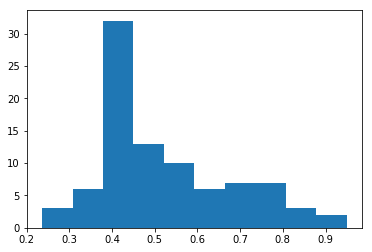

In [120]:
p = np.exp(y)/(np.exp(y)+1)
hist(p)
print p

In [123]:
phe = p>0.5

In [124]:
phe = np.array(phe, dtype=int)
print np.sum(phe)

42


In [139]:
# Read sample names
sample_names = np.loadtxt('data/qt.phe', usecols=0, dtype='S')

In [140]:
# Write phenotype file
np.savetxt('data/phenotype.phe',
           np.vstack((sample_names, np.array(np.ones(89, ), dtype='int'), phe+1)).T,
           fmt='%s %s %s')

Recode the phenotype in the .ped file
  
```
plink --file hapmap1 --pheno phenotype.phe --recode --noweb
mv plink.ped simulated.ped
mv plink.map simulated.ped
```

# Manipulate PLINK output

In [141]:
import pandas as pd

In [153]:
df = pd.read_csv('data/assoc1.assoc', # File name
                 delim_whitespace=True) # Use any white space as delimiter

In [177]:
# sort df by p-value
df_sorted = df.sort_values('P')
print df_sorted[:20]

       CHR         SNP     BP  A1      F_A      F_U  A2  CHISQ             P  \
639      1  rs12045968    861   1  0.45240  0.11700   2  25.01  5.712000e-07   
53018   14   rs1190539  67222   1  0.17860  0.00000   2  18.33  1.857000e-05   
638      1   rs3851890    860   1  0.47620  0.18090   2  17.78  2.486000e-05   
637      1    rs676628    858   1  0.47620  0.19150   2  16.37  5.216000e-05   
5169     1   rs6657743   6707   1  0.16670  0.43480   2  14.84  1.169000e-04   
5887     2   rs1275925   7627   1  0.03571  0.23400   2  14.45  1.437000e-04   
42145   10   rs1172480  53229   1  0.33330  0.61700   2  14.30  1.562000e-04   
44792   11   rs6592035  56619   2  0.19050  0.45740   1  14.27  1.586000e-04   
10141    2   rs6747756  13100   1  0.16670  0.01064   2  13.99  1.834000e-04   
10368    2   rs1474258  13409   1  0.25000  0.05319   2  13.78  2.060000e-04   
18814    4  rs11100479  24195   1  0.10710  0.34040   2  13.62  2.241000e-04   
42144   10    rs756030  53228   1  0.321

## Manhattan plot

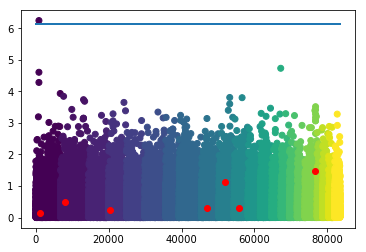

In [185]:
plt.scatter(df.BP, # x = SNP position
            -np.log10(df.P), # y = -log10 p-value (the higher the more significant)
            c=df.CHR) # color by chromosome

plt.scatter(df.BP[causal_SNPs], 
            -np.log10(df.P[causal_SNPs]),
                     color='red')

# significance threshold according to Bonferroni correction
t = -np.log10(0.05/df.shape[0])
plt.plot([0, max(df.BP)], [t, t], lw=2)

In [169]:
# One significant SNP
print min(df.P)

5.7119999999999993e-07

## Q-Q plot

In [178]:
import scipy.stats as ss

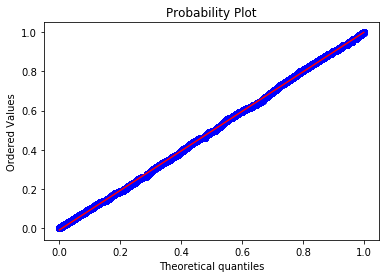

In [180]:
ss.probplot(df.P, dist="uniform", plot=pylab)
plt.show()

In [184]:
df.P[0]

0.73260000000000003